#Analysis of the Fitzhugh Nagumo Model

##No Extensions are performed

###Import all necissary modules

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from JSAnimation import IPython_display
from matplotlib import animation
from scipy.integrate import odeint
from scipy.signal import argrelextrema
%matplotlib inline

###Initialize Constants

In [78]:
abserr = 1.0e-8
relerr = 1.0e-6
stoptime = 100.0 #ms
numpoints = 10*stoptime
times = np.linspace(0,stoptime,numpoints)

###Initialize Variables

In [79]:
alpha = 0.01;
beta = 0.5;
c = 0.01;
z = 0.5;
times = np.linspace(0,time,time/dT)

In [62]:
#Derrivatives
def dV(V,W,alpha,z):
    return V*(alpha+V)*(1-V)-W+z
def dW(V,W,beta,c):
    return beta*V - c*W

#Nullclines
def nullV(alpha,V):
    return -V**3 + (1-alpha)*V**2 + alpha*V +z
def nullW(beta,c,V):
    return beta*V/c

#Bulk derrivative for ode solver
def derr_func(var,t,p):
    alpha,beta,c,z = p
    V, W = var
    f = [V*(alpha+V)*(1-V)-W+z, beta*V - c*W]
    return f

#calculate frequency of model
def calc_freq(t,V):
    max_pts = argrelextrema(V,np.greater)[0]
    time_pts = t[max_pts]
    return 1.0/np.diff(time_pts)[-1]

###Sample Run of Model

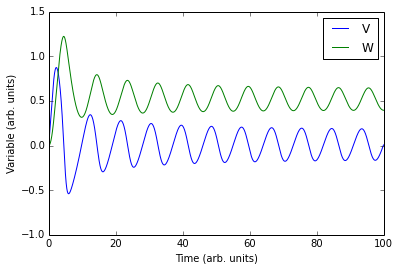

In [84]:
#use ode solver
p = [alpha, beta, c, z]
w0 = [0,0]


wsol = odeint(derr_func, [0,0], times, args=([alpha,beta,c,z],),atol=abserr, rtol=relerr)
V = wsol[:,0]
W = wsol[:,1]
plt.plot(times,V)
plt.plot(times,W)
plt.xlabel('Time (arb. units)')
plt.ylabel('Variable (arb. units)')
plt.legend(['V','W'])

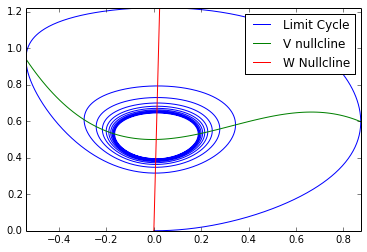

In [65]:
#phase plane
plt.plot(V,W)
Vs = np.linspace(min(V),max(V),100)
V_nullcline = nullV(alpha,Vs)
W_nullcline = nullW(beta,c,Vs)

plt.plot(Vs,V_nullcline)
plt.plot(Vs,W_nullcline)
plt.xlim([min(V),max(V)])
plt.ylim([min(W),max(W)])

plt.legend(['Limit Cycle','V Nullcline','W Nullcline'])


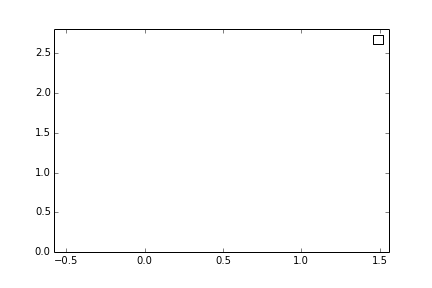
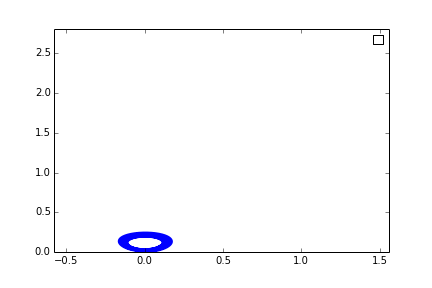
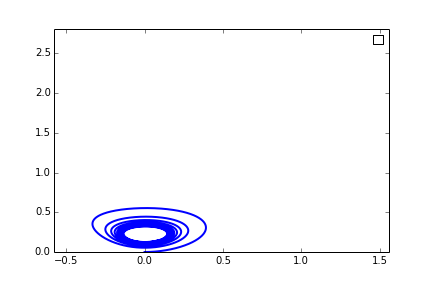
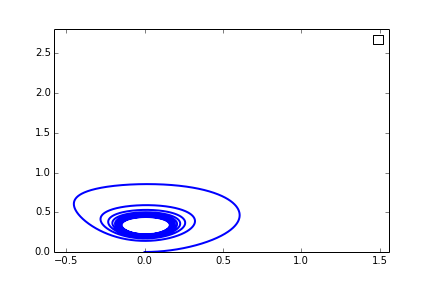
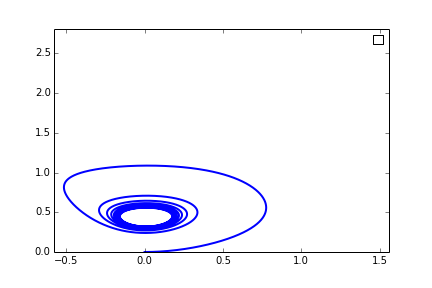
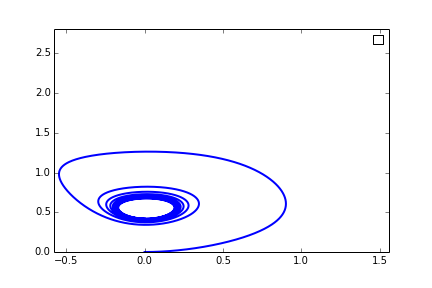
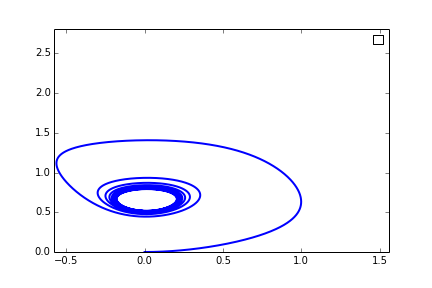
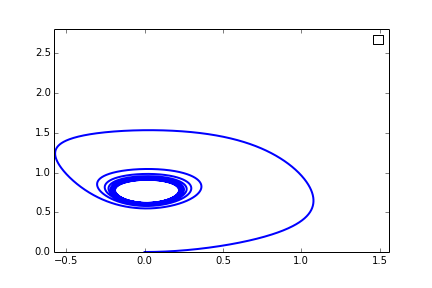
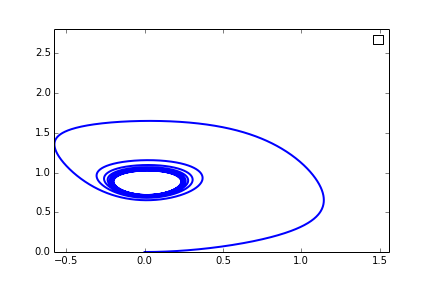
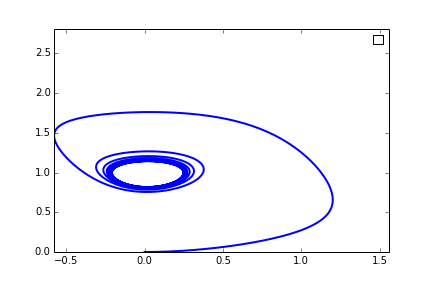
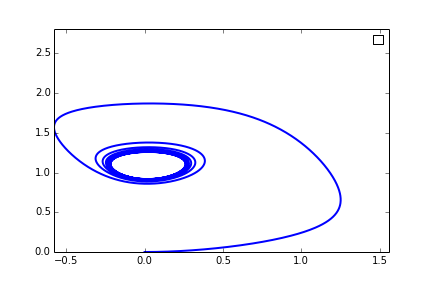
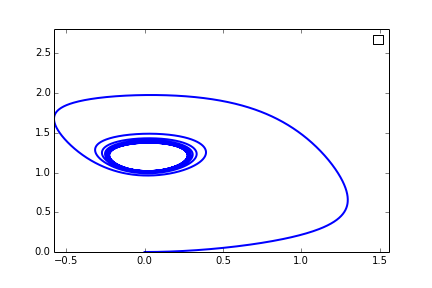
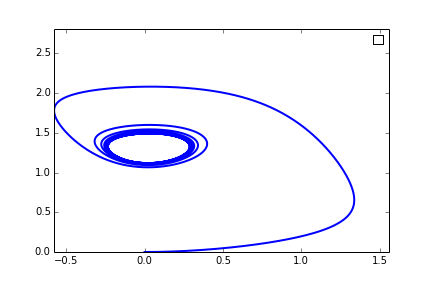
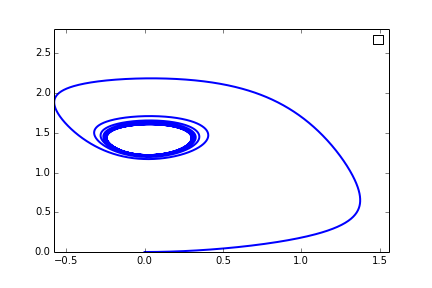
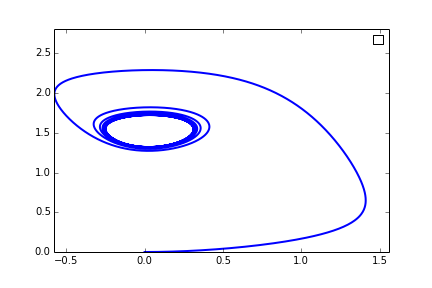
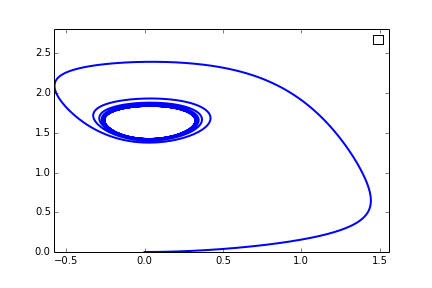
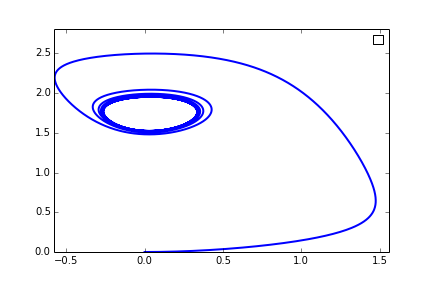
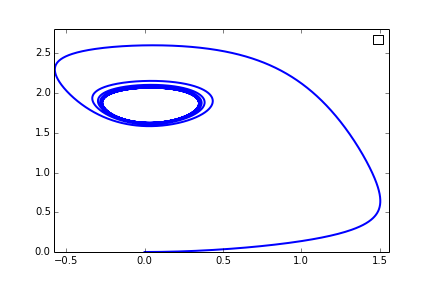
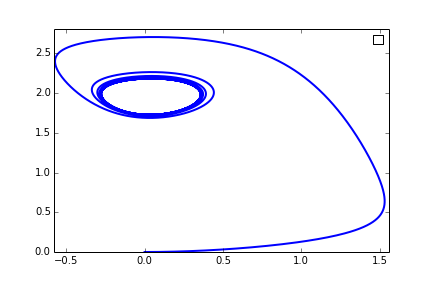
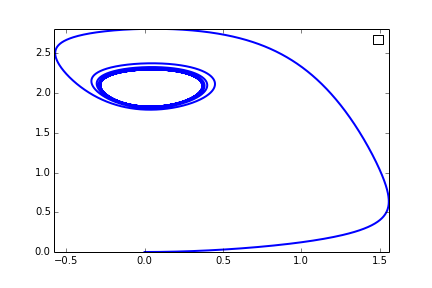

In [102]:
n_z = 20
zs = np.linspace(0,2,n_z)
V_loop = np.zeros((n_z,np.size(V)))
W_loop = np.zeros((n_z,np.size(W)))
for ix,z in enumerate(zs):
    wsol = odeint(derr_func, [0,0], times, args=([alpha,beta,c,z],),atol=abserr, rtol=relerr)
    V = wsol[:,0]
    W = wsol[:,1]
    V_loop[ix,:] = V
    W_loop[ix,:] = W
    
#First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
V_lim = (np.min(np.min(V_loop)),np.max(np.max(V_loop)))
W_lim = (np.min(np.min(W_loop)),np.max(np.max(W_loop)))

ax = plt.axes(xlim=V_lim, ylim=W_lim)

line, = ax.plot([], [], lw=2)
    
def init():
    line.set_data([], [])
    return line,

def animate(i):
    V = V_loop[i,:]
    W = W_loop[i,:]
    line.set_data(V, W)
    return line


animation.FuncAnimation(fig, animate, init_func=init,frames=20, interval=100, blit=True)

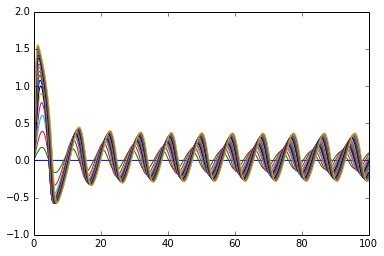

In [71]:
for i in np.arange(n_z):
    plt.plot(times,V_loop[i,:])